##data challenge - exploratory
You are a visiting Professor in the first and only University of Mars, which admits exclusively Martians (off-planet tuition would be too expensive for Earthlings anyway). You have joined the Department of Astronomy and are in charge of teaching Astrometrics. Unfortunately the university is quite overcrowded and each semester there are close to 13,000 martian students that take Astrometrics. Given the size of your class, and a disturbing lack of teaching assistants, you are forced to limit the number of questions given to each student on the mid-term exam to only five multiple choice questions. To further complicate matters the department head has mandated that all test questions be pulled from a bank of approximately 400 “approved” test questions. To increase the robustness and ease of creation of your midterm exam you decide to randomly and uniformly choose 5 questions from the question bank for each student. This means that each student’s exam consists of disjoint, intersecting, or identical sets of 5 questions. To assist you with running such a large class, the university has provided you with last year’s student performance data (where the professor created exams using a process similar to your own). Additionally, the department head has admitted to you that she thinks that not all the questions in the “approved” question bank are actually useful for evaluating each student’s relative understanding of Astrometrics. She also warns you that while it is OK not to use all the questions from the bank, you must, at minimum, use 50% of them in order to achieve sufficient coverage of the curriculum. With the mid-term exam only a few days away, which questions should you exclude from the exam generation algorithm such that the exam results will provide the most meaningful ranking of the students in the class? Why? The data set you are given by the department has one record per line, where each record consists of: A unique identifier for a question A unique identifier for a student The correctness of a student's response. A correct answer is marked as a 1; an incorrect response is marked as a 0.

####Plan:
1) Read data into dataframe and examine
 - (size) shape, data types and names are as expected
 - check if NaN are present
 - check basic statistics, e.g., min, max, mean, std and percentiles.
 
2) Explore data:
- plot (are distributions as expected? (e.g. binary for answer/correct column) Two different sets of questions  are shown (is there a difference between two sets?). 

3) Define irrelevant question:
- repeated questions (testing exactly the same knowledge) - calculate correlations
- what is the shape of question score probability distribution (expect Gaussian, few people do bad, few have excellent scores and the majority is in between)
- look for outliers, e.g., students who perform well on average can't answer particular question, questions that were answered by everyone probably are not meaningful either, students who took a test and answerd none of the questions

4) After subtracting irrelevant questions from the list, divide probability distribution of question score into five ranges, and sample randomly and uniformly one question from each range. This way each student will have a set of questions with the same/similar difficulty level.  

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv("astudentData.csv", header=False, encoding="utf-8-sig")

In [6]:
# Check for data dimentions, types, and column names
print "Data shape: ", df.shape
print "Data types: ", df.dtypes
print "Columns: ", df.columns

Data shape:  (409519, 3)
Data types:  question_id    int64
user_id        int64
correct        int64
dtype: object
Columns:  Index([u'question_id', u'user_id', u'correct'], dtype='object')


In [7]:
# Check if there are any NaN values in the data
print 'Checking for NaNs:'
print pd.isnull(df).any() # check for missing data ==> NO NaNs

Checking for NaNs:
question_id    False
user_id        False
correct        False
dtype: bool


In [8]:
# Display data statistics
print 'Data stats: '
print df.describe()
# student ids and question ids are interesting

Data stats: 
         question_id        user_id        correct
count  409519.000000  409519.000000  409519.000000
mean     5148.830682   50890.236897       0.629021
std      5672.732535   32788.210946       0.483067
min        13.000000      34.000000       0.000000
25%       648.000000   24357.000000       0.000000
50%      1619.000000   44044.000000       1.000000
75%     12763.000000   78827.000000       1.000000
max     15872.000000  118275.000000       1.000000


###Exploratory research:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a94b890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b657390>]], dtype=object)

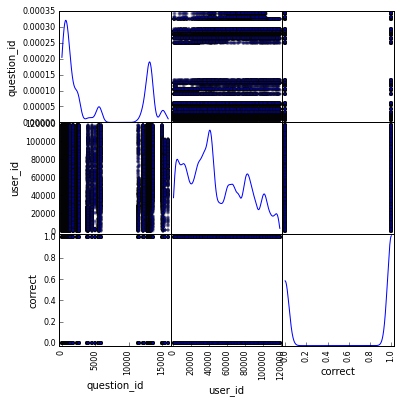

In [9]:
# Plot data
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df,alpha=0.2, figsize=(6,6),diagonal='kde')

##### Answers (correct) are indeed binary, questions_ids looks like two different sets over large number, can't tell 
 much about user_id either. Counts of questions and students (below) are in agreement with provided informarion.

In [10]:
def count(dataframe,column):
    counts = len(dataframe.groupby([column]))
    return counts

In [11]:
# Check if data indeed is as it is supposed to be - if number of questions and students are ~400, and ~13k.
print 'Number of questions in the data = %d' % count(df,'question_id')
print 'Number of students = %d' % count(df,'user_id')

Number of questions in the data = 391
Number of students = 12839


## In search for irrelevant questions:
### 1) Check for questions collinearity 
If questions are correlated (corr. very close to 1) that would imply questions are exactly testing the same knowledge and only one of them should be left in the data set, the rest should be removed.
First of all, I'm assuming that all questions are meaningful and can be used for correlation calculations. 
Secondly, questions have different length (were taken by different number of students), as seen in the plot below. That only allows me to calculate correlations between questions of the same length.

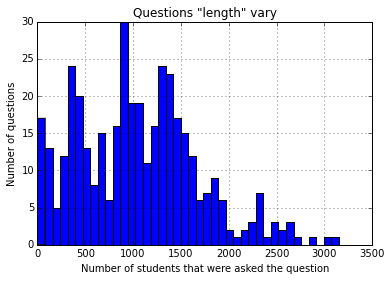

In [12]:
q_length=df.groupby('question_id')['correct'].count()
q_length.hist(bins=40)
plt.xlabel('Number of students that were asked the question')
plt.ylabel('Number of questions')
plt.title('Questions "length" vary ')
plt.show()
# e.g., question #13 was given to 715 student (column length)
# print q_length.duplicated()

In [13]:
# Rearranging data - each column is a question_id, and rows are asociated 'correct' values
df['yindex'] = df.groupby("question_id").cumcount()
new_df = df.pivot(index='yindex',columns='question_id',values='correct')
new_df.head()

question_id,13,21,26,27,28,37,44,45,53,54,...,15065,15071,15142,15147,15403,15412,15413,15415,15865,15872
yindex,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,1,1,1,0
1,0,1,0,1,1,1,1,0,1,1,...,0,1,1,0,0,0,1,0,1,0
2,0,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0,0,1,1,1
3,1,1,0,1,1,1,1,0,1,1,...,0,1,1,1,0,0,0,0,1,0
4,1,1,1,1,0,1,1,1,1,0,...,1,0,1,1,1,0,0,0,0,0


In [14]:
duplicates = q_length[q_length.duplicated(take_last=True) | q_length.duplicated()]
col2 = []
for duplicate in duplicates:
    col2.append(duplicate)
s2=pd.Series(col2)

col1 = duplicates.index.tolist()
s1 = pd.Series(col1)

df2=pd.concat([s1, s2], axis=1)
df2.columns = ['question_id', 'counts']
results = df2.sort(['counts'])

same_length = []
groups = results.groupby('counts')
for name, group in groups:
    same_length.append(group.question_id.tolist())

threshold = 0.9 # setting threshold for question rejection by correlation (~1)
for same in same_length:
    q = []
    for index, item in enumerate(same):
        q.append(new_df[item].dropna().tolist())
    correlations = np.corrcoef(q)
    array_size = len(same)
    mask = np.ones((array_size,array_size))
    mask = (mask - np.diag(np.ones(array_size))).astype(np.bool)
    max_corr =  np.amax(correlations[mask])
    if max_corr > threshold:
        remove_corr = same[0]
        print "Correlation = ", max_corr, ", identical questions: ",remove_corr

print "Found that only q# 12803 and 12710 are equivalent and will remove one of them from set of 391"
print "Turned out question set got reduced to 390"

Correlation =  1.0 , identical questions:  12803
Found that only q# 12803 and 12710 are equivalent and will remove one of them from set of 391
Turned out question set got reduced to 390


### 2) Question Performance/Score
Let's look at question score (question mean).  

In [16]:
newdf = df.copy()
newdf.head()

,question_id,user_id,correct,yindex
0,13,63994,0,0
1,13,7633,0,1
2,13,33056,0,2
3,13,3714,1,3
4,13,17535,1,4


In [17]:
def func(newdf):
    newdf['user_mean'] = newdf['correct'].mean()
    return newdf

In [18]:
newdf = newdf.groupby('user_id').apply(func)

In [19]:
def func(newdf):
    newdf['question_mean'] = newdf['correct'].mean()
    return newdf

In [20]:
newdf = newdf.groupby('question_id').apply(func)
newdf.head()

,question_id,user_id,correct,yindex,user_mean,question_mean
0,13,63994,0,0,0.304000,0.673893
1,13,7633,0,1,0.840336,0.673893
2,13,33056,0,2,0.550000,0.673893
3,13,3714,1,3,0.916667,0.673893
4,13,17535,1,4,0.958333,0.673893


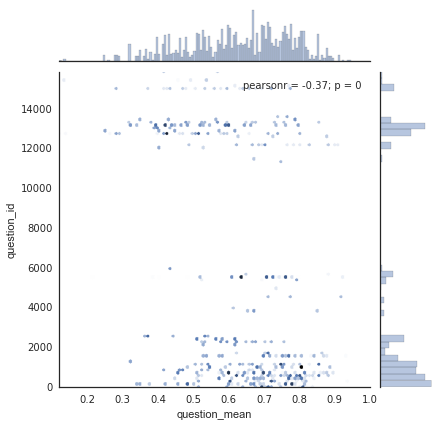

In [21]:
# Quesiton performance/score. What is there athe difference between large and small question_IDs?
import seaborn as sns
x=newdf['question_mean']
y=newdf['question_id']
with sns.axes_style("white"):
    sns.jointplot(x,y,kind="hex")

#### Distributions of question_mean/score seen in the plot above are very diferent for questions with IDs below and above ~8000. 
My expectations were closer to the distribution of large question ID numbers (Please see the mean and variance below
for quesiton_id above the threshold, >threshold). Moreover, plot indicates that there are some questions with a score close to zero (I would consider these questions as irreleveant questions - maybe they were not clear or phrased uncorrectly). 

In [22]:
def stats(x):
    questions_char = {}
    mu = x.mean()
    sigma = x.std()
    ratio = sigma/mu
    x_min = mu - 3* sigma
    x_max = mu + 3 * sigma
    questions_char["threshold"] = threshold
    questions_char["mean"] = round(mu,2)
    questions_char["s_m_ratio"] = round(ratio,2)
    questions_char["lower_lim"] = round(x_min,2)
    questions_char["upper_lim"] = round(x_max,2)
    return questions_char

In [23]:
threshold = 10000

x=newdf['question_mean'][newdf['question_id']<threshold]
stats(x)

{'lower_lim': 0.29,
 'mean': 0.66,
 's_m_ratio': 0.19,
 'threshold': 10000,
 'upper_lim': 1.04}

In [24]:
x=newdf['question_mean'][newdf['question_id']>threshold]
stats(x)

{'lower_lim': 0.09,
 'mean': 0.55,
 's_m_ratio': 0.28,
 'threshold': 10000,
 'upper_lim': 1.01}

### 3) Question vs. Student Performance/Score on Average

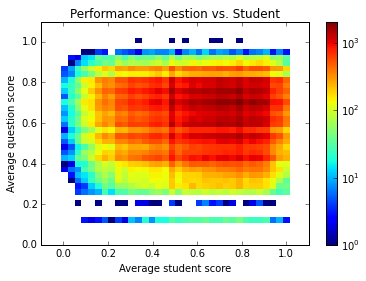

In [11]:
from matplotlib.colors import LogNorm
plt.hist2d(newdf['user_mean'],newdf['question_mean'],bins=40, range=[[-0.1,1.1],[0.,1.1]], norm=LogNorm())
plt.xlabel('Average student score')
plt.ylabel('Average question score')
plt.title('Performance: Question vs. Student')
plt.colorbar()
plt.show()

#### This plot shows outliers:
- questions with score (average question score <25%) below 25% could be irrelevant,
particularly if students had overall good performance
- average question score = 100%, question is not testing knowledge if everyone (regardless of their grade) got 
it right
- set of questions with average student score = 0. It needs to be meantioned that majority of these students took 
several questions, often around 20.

In [35]:
def mean_d(feature):
    f_mean = df.groupby(feature)['correct'].aggregate(np.mean)
    return f_mean

In [36]:
def sum_d(feature):
    f_sum = df.groupby(feature)['correct'].aggregate(np.size)
    return f_sum

In [37]:
def extract_from_list(q_mean,q_sum):
    list0_q=[]
    list2_q=[]
    list10_q = []
    for index in q_mean.index:
        if q_mean[index] == 0:
            #print index, q_mean[index], q_sum[index]
            list0_q.append(index)
        elif q_mean[index] <= 0.25:
            #print index, q_mean[index], q_sum[index]
            list2_q.append(index)
        elif q_mean[index] == 1.0:
            #print index, q_mean[index], q_sum[index]
            list10_q.append(index)
    return list0_q, list2_q, list10_q

In [39]:
question_mean = mean_d('question_id')
question_sum = sum_d('question_id')
print extract_from_list(question_mean,question_sum)[1:]
print 'Question ids to be excluded based on question score (<25% and =100%)'

([5566, 12717, 12719, 12755, 15412], [12665])
Question ids to be excluded based on question score (<25% and =100%)


In [29]:
student_mean = mean_d('user_id')
student_sum = sum_d('user_id')
extract_from_list(student_mean,student_sum)[0] 
# This should be investigated further and it might significantly reduce the list of questions. Numbers below
# correspond to user_ids with a score==0 (didn't answer any questions correctly). I think this might be an important 
# source of 'irrelevant' questions because students usualy took several or more questions. It's hard to score 0 taking
# e.g., 10 or 20 questions. 

[10420,
 11821,
 12310,
 23448,
 28198,
 29296,
 30755,
 38966,
 63197,
 71542,
 73994,
 80537,
 87046,
 92832,
 106480,
 107269,
 107660,
 111410,
 113096,
 116818]

In [30]:
import itertools
l1 = [remove_corr.tolist()]
l2 = extract_from_list(question_mean,question_sum)[1]
l3 = extract_from_list(question_mean,question_sum)[2]
#l4 = extract_from_list(student_mean,student_sum)[0] 

to_be_removed = list(set([i for i in itertools.chain(l1,l2,l3)]))
print 'Number of questions to be removed = %d' % len(to_be_removed)
print to_be_removed

Number of questions to be removed = 7
[12803, 12717, 12719, 12755, 15412, 12665, 5566]


In [31]:
from copy import copy
def subtract_lists(a,b):
    a = copy(a)
    for i in b:
        if i in a:
            a.remove(i)
    return a

In [32]:
all_questions = new_df.columns.tolist()
print len(all_questions), len(to_be_removed)
final_list = subtract_lists(all_questions, to_be_removed)
print 'Number of questions tused for midterm = %d' % len(final_list)

391 7
Number of questions tused for midterm = 384


### 4) Divinding into semi-equal intervals in probability distributions and selecting randomly a question from 
each of the ranges.

In [33]:
obj = {}
for i in range(1,6):
    obj['l' + str(i)] = []

for index in mean_d('question_id').index:
    if index not in final_list:
        continue
    else:
        if mean_d('question_id')[index]  < 0.4:
            obj['l1'].append(index)
        elif mean_d('question_id')[index]  < 0.55:
            obj['l2'].append(index)
        elif mean_d('question_id')[index]  < 0.7:
            obj['l3'].append(index)   
        elif mean_d('question_id')[index]  < 0.8:
            obj['l4'].append(index)  
        else:
            obj['l5'].append(index)
            
for i in range(1,6):  
    print len(obj['l'+ str(i)]) 
    print obj['l'+ str(i)] 
    print

25
[159, 167, 223, 1232, 2514, 2516, 5601, 12730, 12749, 12777, 12821, 12932, 12949, 13078, 13080, 13215, 13221, 13228, 13241, 13292, 13514, 15049, 15059, 15062, 15065]

83
[65, 92, 130, 172, 190, 276, 436, 471, 527, 602, 631, 716, 760, 809, 813, 818, 910, 914, 1011, 1112, 1122, 1135, 1143, 1593, 1608, 2193, 2208, 2234, 2489, 2497, 2504, 2517, 5456, 5475, 5553, 5584, 5916, 12098, 12109, 12208, 12209, 12710, 12716, 12718, 12720, 12729, 12745, 12752, 12754, 12776, 12783, 12790, 12797, 12810, 12812, 12817, 12929, 13074, 13205, 13207, 13212, 13217, 13224, 13229, 13235, 13236, 13243, 13274, 13277, 13282, 13286, 13510, 15011, 15032, 15050, 15053, 15057, 15061, 15063, 15403, 15413, 15415, 15872]

118
[13, 21, 26, 27, 45, 53, 66, 102, 114, 141, 155, 166, 182, 194, 206, 226, 242, 243, 337, 349, 369, 375, 397, 445, 456, 470, 504, 537, 575, 595, 613, 637, 648, 691, 696, 697, 705, 707, 708, 713, 714, 753, 754, 766, 807, 810, 817, 864, 998, 999, 1000, 1014, 1049, 1104, 1109, 1110, 1119, 1136, 1140,

In [34]:
import random

all_students_sets = []
students = count(df,'user_id')

for student in range(1,students+1):
    questions = []
    for i in range(1,6):
        index = random.randint(0, len(obj['l'+ str(i)])-1)
        questions.append(obj['l'+ str(i)][index])
    all_students_sets.append(questions)
print "Number of 5-question sets = %d" %len(all_students_sets)
print 
print all_students_sets

Number of 5-question sets = 12839

[[12932, 13510, 12734, 2270, 1607], [12949, 12817, 537, 664, 1638], [13514, 2208, 15071, 647, 1638], [13514, 2504, 707, 13513, 618], [13078, 172, 691, 13208, 1124], [13221, 15057, 445, 815, 1151], [12932, 5584, 242, 12663, 700], [13080, 12790, 166, 1612, 57], [13215, 910, 13239, 563, 544], [223, 15053, 369, 169, 360], [12821, 13236, 12674, 1089, 63], [223, 276, 707, 15013, 12168], [13292, 13074, 1119, 515, 56], [13215, 12797, 13275, 710, 12168], [13514, 15050, 15052, 1637, 1604], [15062, 12752, 1140, 654, 618], [2514, 15403, 697, 664, 3828], [13078, 2489, 708, 383, 12168], [12749, 276, 15031, 2254, 5515], [13215, 65, 5580, 11390, 58], [12821, 5456, 5594, 186, 438], [15059, 5916, 397, 1633, 13280], [2516, 2208, 12171, 1606, 661], [2516, 15032, 15029, 581, 635], [12730, 190, 2214, 4497, 268], [12749, 760, 3917, 13214, 700], [159, 1122, 1110, 186, 606], [159, 65, 13278, 2254, 396], [13221, 12718, 5620, 441, 396], [159, 1011, 697, 692, 1042], [2514, 1593,